## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os

os.environ["ROBOFLOW_API_KEY"] = "yfH3xqvd7SjFB7VD68xU"

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Tue Jun 24 11:31:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              2W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

C:\Users\zabit\Documents\GitHub\street-surveillance


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [ ]:
# %pip install -q git+https://github.com/sunsmarterjie/yolov12.git

In [ ]:
# %pip install -q roboflow supervision

## Download dataset from Roboflow Universe

In [5]:
import os
from roboflow import download_dataset

# Local directory where datasets are stored
dataset_dir = os.path.expanduser("~/.cache/roboflow/steamlt/vehicle-and-human-recognition/31/yolov8")

# Check if the dataset already exists
if not os.path.exists(dataset_dir):
    print("📥 Downloading dataset...")
    dataset = download_dataset('https://universe.roboflow.com/steamlt/vehicle-and-human-recognition/31', 'yolov8')
else:
    print("✅ Dataset already downloaded.")
    
    # If you still need a dataset object (for .location, etc.)
    class DummyDataset:
        location = dataset_dir
    dataset = DummyDataset()


📥 Downloading dataset...
loading Roboflow workspace...
loading Roboflow project...


In [6]:
import os

# Show files in the dataset directory
print(os.listdir(dataset.location))


['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
file_path = os.path.join(dataset.location, "data.yaml")

# Step 1: Read all lines
with open(file_path, "r") as f:
    lines = f.readlines()

# Step 2: Remove last 4 lines
lines = lines[:-4]

# Step 3: Append the desired YAML entries
lines += [
    "test: ../test/images\n",
    "train: ../train/images\n",
    "val: ../valid/images\n"
]

# Step 4: Write back to the file
with open(file_path, "w") as f:
    f.writelines(lines)

print("✅ YAML file updated successfully.")


✅ YAML file updated successfully.


In [8]:
with open(file_path, "r") as f:
    print(f.read())

names:
- Car
- Human
nc: 2
roboflow:
  license: CC BY 4.0
  project: vehicle-and-human-recognition
  url: https://universe.roboflow.com/steamlt/vehicle-and-human-recognition/dataset/31
  version: 31
test: ../test/images
train: ../train/images
val: ../valid/images



## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
%pip install huggingface-hub

  Obtaining dependency information for huggingface-hub from https://files.pythonhosted.org/packages/33/fb/53587a89fbc00799e4179796f51b3ad713c5de6bb680b2becb6d37c94649/huggingface_hub-0.33.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/514.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/514.8 kB ? eta -:--:--
   -- ------------------------------------ 30.7/514.8 kB 435.7 kB/s eta 0:00:02
   ---- ---------------------------------- 61.4/514.8 kB 656.4 kB/s eta 0:00:01
   ------------------- -------------------- 256.0/514.8 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 514.8/514.8 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from ultralytics import YOLO

model = YOLO('yolov12n.yaml')

results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=50,             # Reasonable training length
    imgsz=640,             # Keep it 640 or reduce to 512 if OOM
    batch=-1,               # Safe starting point; try 4 if you hit OOM
    workers=0,             # Prevents DataLoader crashes on Windows
    device=0               # Explicitly use the GPU
)

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.158 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.63  Python-3.11.5 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov12n.yaml, data=C:\Users\zabit\Documents\GitHub\street-surveillance\Vehicle-and-human-recognition-31/data.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=0, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=Tru

train: Scanning C:\Users\zabit\Documents\GitHub\street-surveillance\Vehicle-and-human-recognition-31\train\labels... 26

train: New cache created: C:\Users\zabit\Documents\GitHub\street-surveillance\Vehicle-and-human-recognition-31\train\labels.cache


AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce GTX 1650) 4.00G total, 0.04G reserved, 0.02G allocated, 3.94G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2520054        5.98         0.646         113.7         566.5        (1, 3, 640, 640)                    list
     2520054       11.96         1.093         84.32         164.4        (2, 3, 640, 640)                    list
     2520054       23.92         1.827         123.2         181.2        (4, 3, 640, 640)                    list
     2520054       47.84         3.544         148.6         311.2        (8, 3, 640, 640)                    list
     2520054       95.67         6.312          1870          1922       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 5 for CUDA:0 2.38G/4.00G (59%) 


train: Scanning C:\Users\zabit\Documents\GitHub\street-surveillance\Vehicle-and-human-recognition-31\train\labels.cache
val: Scanning C:\Users\zabit\Documents\GitHub\street-surveillance\Vehicle-and-human-recognition-31\valid\labels... 120 

val: New cache created: C:\Users\zabit\Documents\GitHub\street-surveillance\Vehicle-and-human-recognition-31\valid\labels.cache


Plotting labels to C:\Users\zabit\Documents\GitHub\street-surveillance\runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005078125), 127 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\zabit\Documents\GitHub\street-surveillance\runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.11G      5.616      4.419      4.149         49        640: 100%|██████████| 54/54 [00:28<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04

                   all        120       1900          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.1G      4.373      3.727      3.566        193        640:  78%|███████▊  | 42/54 [00:20<00:05,  2.


KeyboardInterrupt: 

## Evaluate fine-tuned YOLOv12 model

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train2/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2.jpg
confusion_matrix.png				   train_batch680.jpg
events.out.tfevents.1750749753.f2a89faf100c.337.1  train_batch681.jpg
F1_curve.png					   train_batch682.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


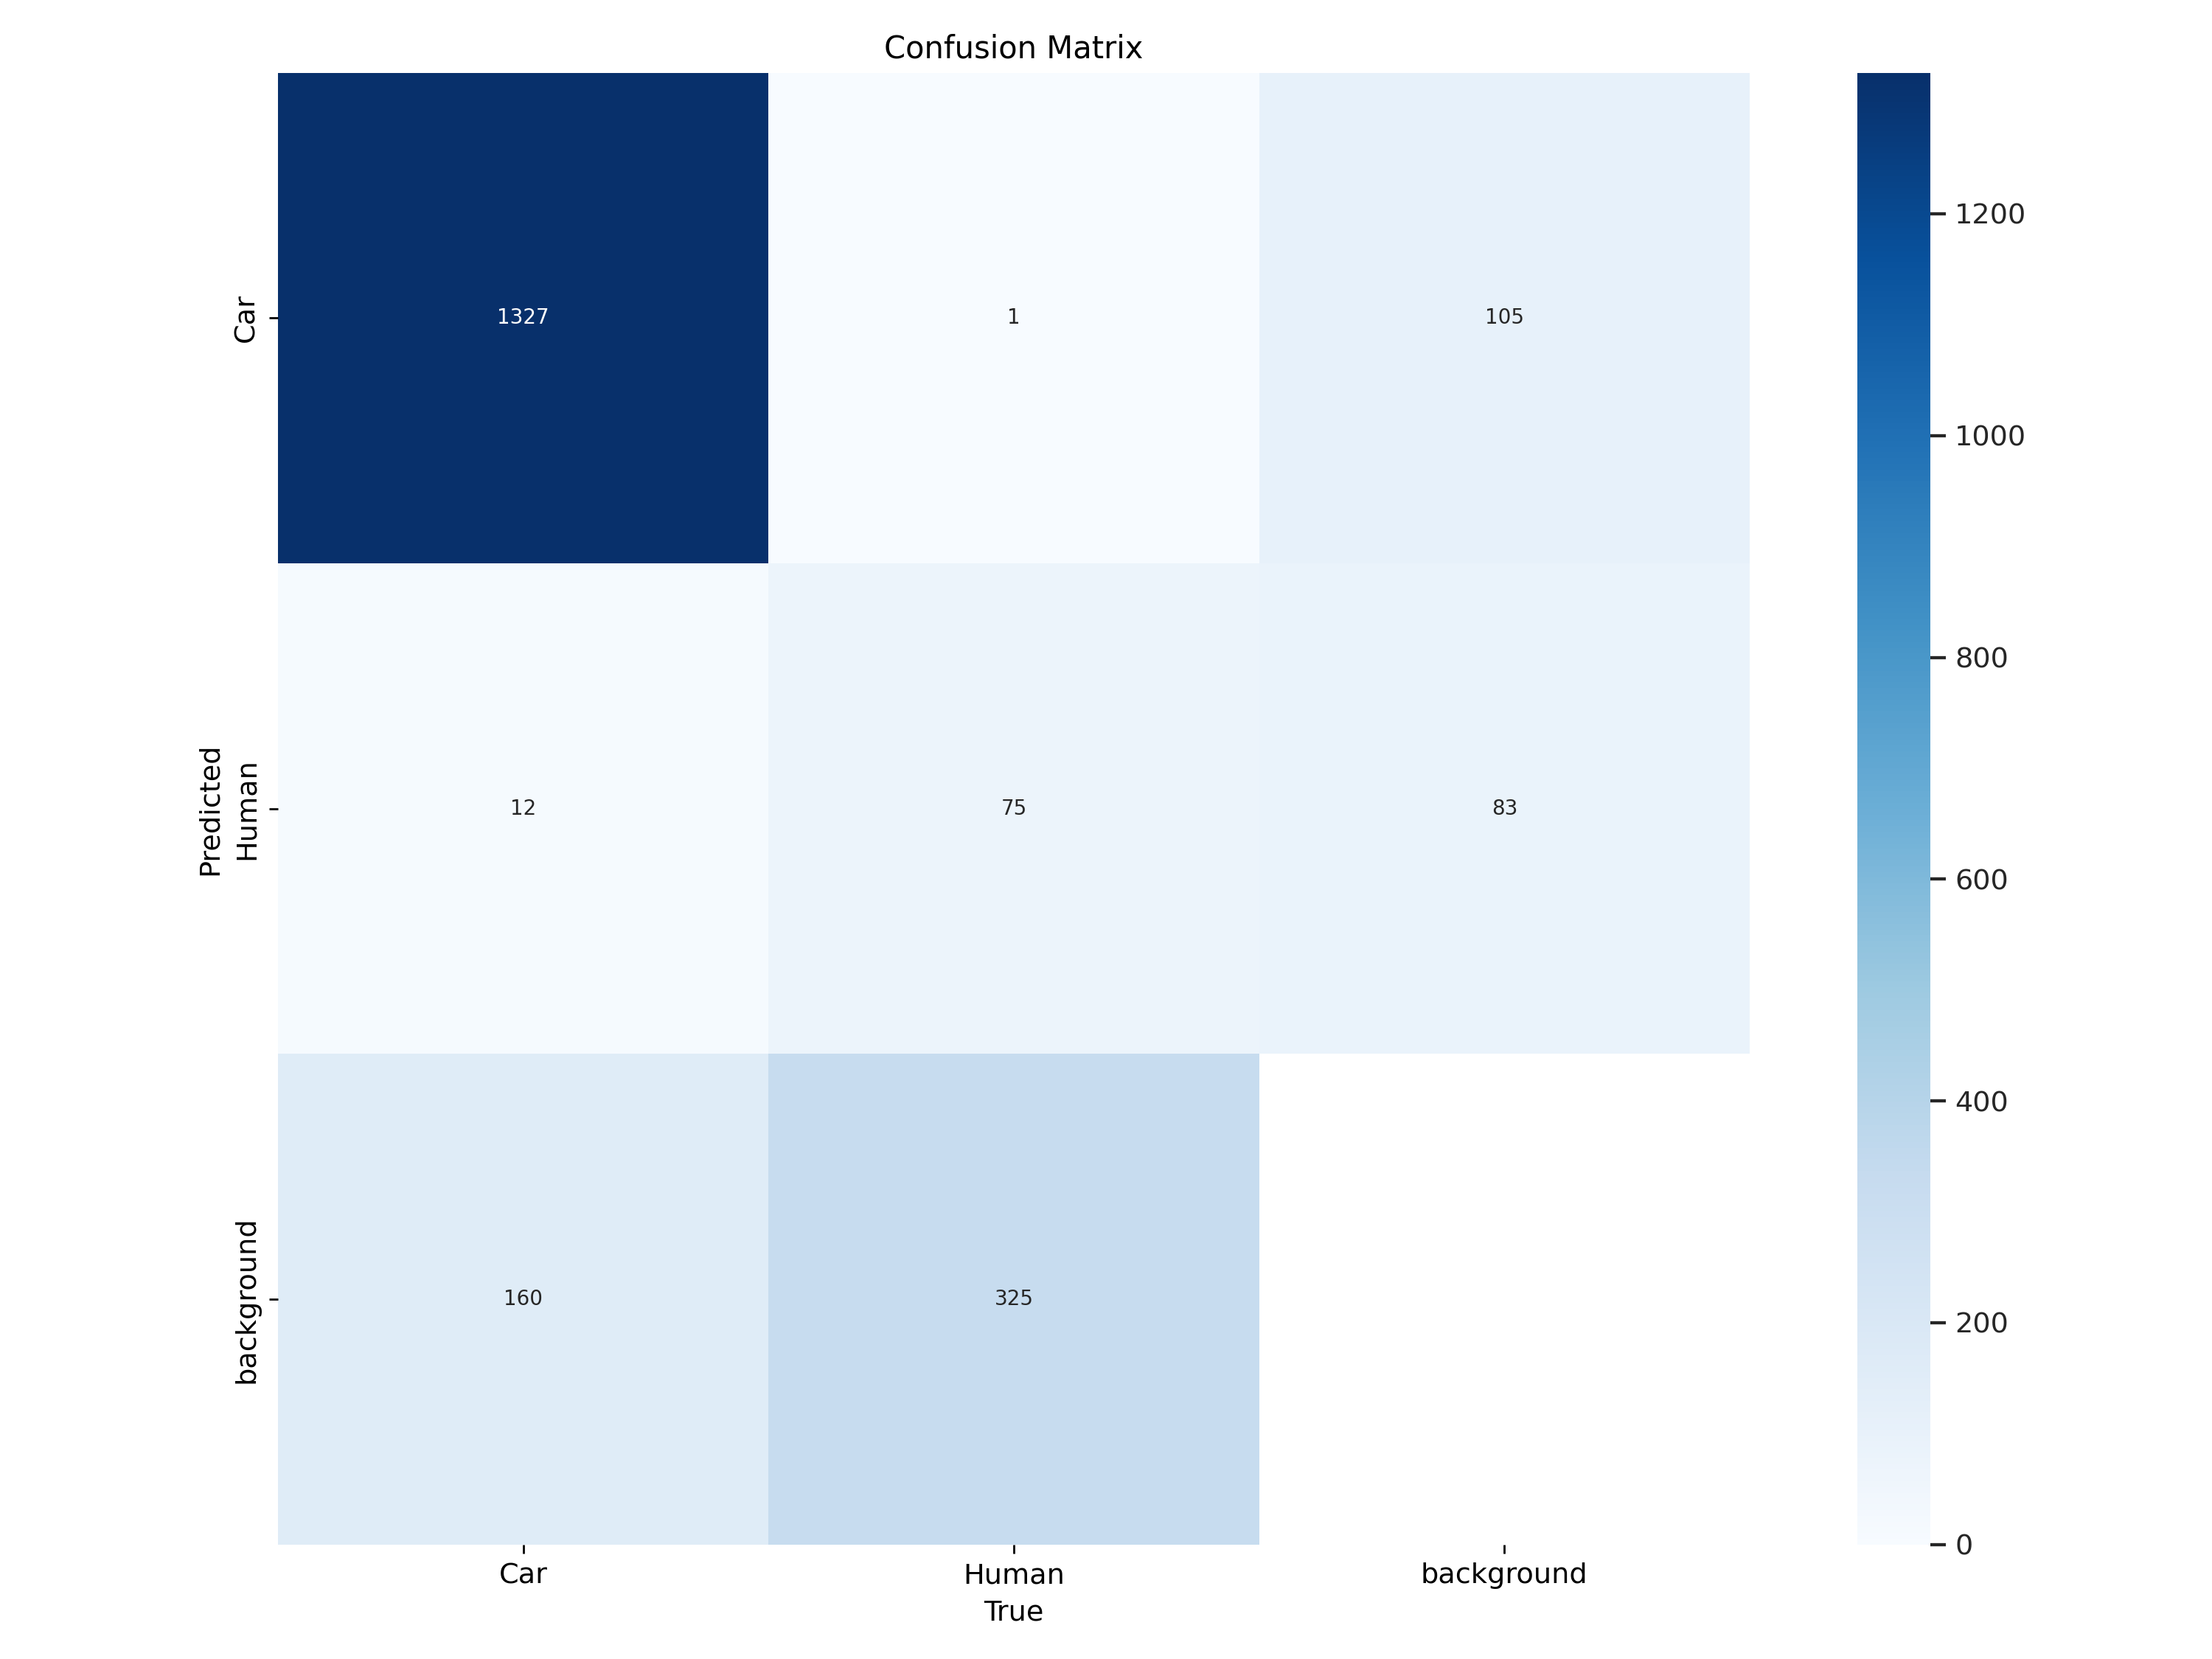

In [32]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

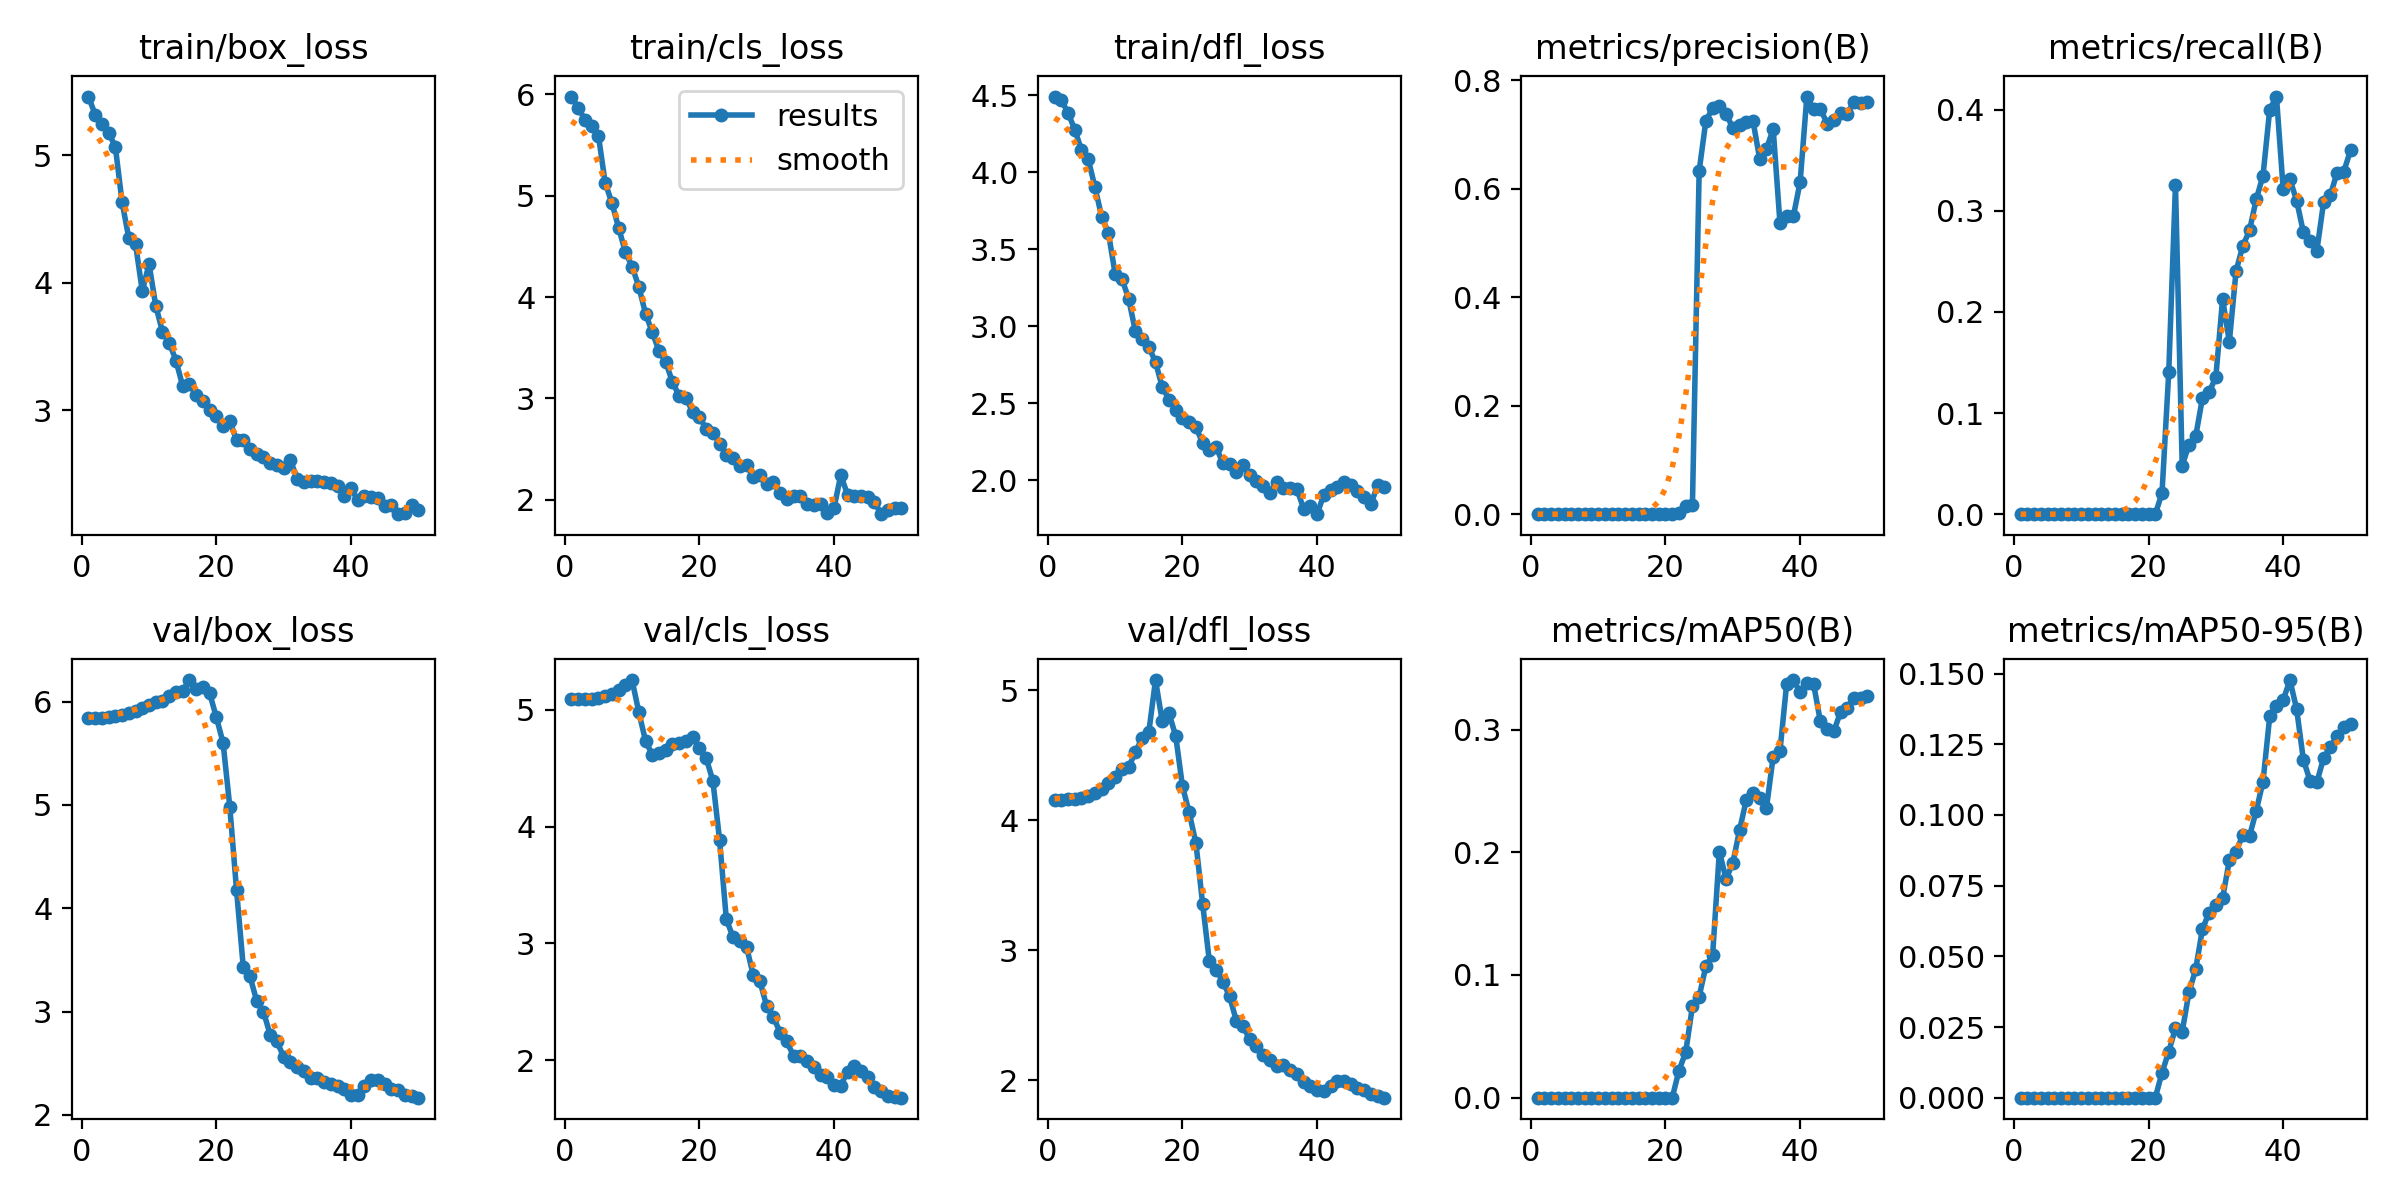

In [33]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [34]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Car', 'Human']

In [35]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [36]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3372347071183289
mAP 50 0.49147171615137136
mAP 75 0.3893520242115307


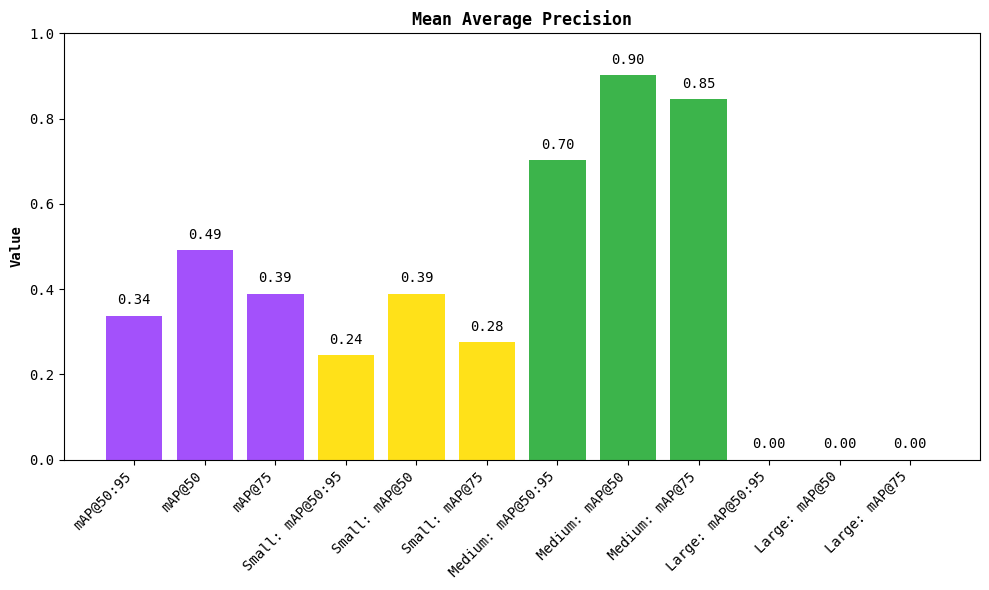

In [37]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [38]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

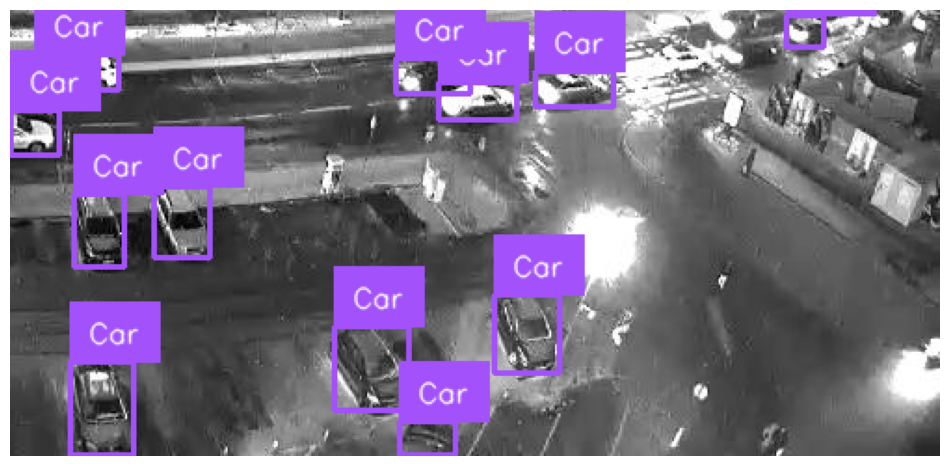

In [43]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)